# BDA Final Project Sentiment Analysis Models

#### We will train a supervised training model to predict if a tweet has a positive or negative sentiment.

#### Load in requirements

Import packages

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
sns.set_style('darkgrid')

import nltk
nltk.download('twitter_samples')
nltk.download('punkt')
from nltk.corpus import twitter_samples 

[nltk_data] Downloading package twitter_samples to /root/nltk_data...
[nltk_data]   Unzipping corpora/twitter_samples.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
# import necessary libraries for neural network models
import tensorflow.keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, Dense, SimpleRNN, Activation, Dropout, Conv1D
from tensorflow.keras.layers import Embedding, Flatten, LSTM, GRU
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping
import pandas as pd
import numpy as np
import spacy
from sklearn.metrics import classification_report

Mount Google drive

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


Unzip pre-trained word-embedding

In [ ]:
!unzip gdrive/My\ Drive/Fall\ 2021/EECS6895-BDA/Final\ Project/glovetwitter27b100dtxt.zip

Archive:  gdrive/My Drive/Fall 2021/EECS6895-BDA/Final Project/glovetwitter27b100dtxt.zip
  inflating: glove.twitter.27B.200d.txt  


#### Load in dataset

Load the positive & negative tweets. Use tweets as dataset to train models.

In [ ]:
all_positive_tweets = twitter_samples.strings('positive_tweets.json')
all_negative_tweets = twitter_samples.strings('negative_tweets.json')

positive_dict = pd.DataFrame({'tweet': all_positive_tweets, 'sentiment': 'positive'})
negative_dict = pd.DataFrame({'tweet': all_negative_tweets, 'sentiment': 'negative'})
tweets = positive_dict.append(negative_dict, ignore_index = True)

#### Data preprocessing and loading in model

Data preprocessing functions

In [ ]:
def load_glove_model(glove_file):
    print("[INFO]Loading GloVe Model...")
    model = {}
    with open(glove_file, 'r') as f:
        for line in f:
            split_line = line.split()
            word = split_line[0]
            embeddings = [float(val) for val in split_line[1:]]
            model[word] = embeddings
    print("[INFO] Done...{} words loaded!".format(len(model)))
    return model
# adopted from utils.py
nlp = spacy.load("en")

def remove_stopwords(sentence):
    '''
    function to remove stopwords
        input: sentence - string of sentence
    '''
    new = []
    # tokenize sentence
    sentence = nlp(sentence)
    for tk in sentence:
        if (tk.is_stop == False) & (tk.pos_ !="PUNCT"):
            new.append(tk.string.strip())
    # convert back to sentence string
    c = " ".join(str(x) for x in new)
    return c


def lemmatize(sentence):
    '''
    function to do lemmatization
        input: sentence - string of sentence
    '''
    sentence = nlp(sentence)
    s = ""
    for w in sentence:
        s +=" "+w.lemma_
    return nlp(s)

def sent_vectorizer(sent, model):
    '''
    sentence vectorizer using the pretrained glove model
    '''
    sent_vector = np.zeros(200)
    num_w = 0
    for w in sent.split():
        try:
            # add up all token vectors to a sent_vector
            sent_vector = np.add(sent_vector, model[str(w)])
            num_w += 1
        except:
            pass
    return sent_vector

Convert data to Numpy arrays

In [ ]:
data_X = tweets['tweet'].to_numpy()
data_y = pd.get_dummies(tweets['sentiment']).to_numpy()

Load pre-trained model and vectorize input

In [ ]:
# load the glove model
glove_model = load_glove_model("glove.twitter.27B.200d.txt")
# number of vocab to keep
max_vocab = 18000
# length of sequence that will generate
max_len = 15

tokenizer = Tokenizer(num_words=max_vocab)
tokenizer.fit_on_texts(data_X)
sequences = tokenizer.texts_to_sequences(data_X)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))
data_keras = pad_sequences(sequences, maxlen=max_len, padding="post")

[INFO]Loading GloVe Model...
[INFO] Done...1193514 words loaded!
Found 21572 unique tokens.


#### Run Neural Network Models

Create train/test split

In [ ]:
from sklearn.model_selection import train_test_split
train_X, valid_X, train_y, valid_y = train_test_split(data_keras, data_y, test_size = 0.3, random_state=42)

Create word embedding matrix

In [ ]:
# calcultate number of words
nb_words = len(tokenizer.word_index) + 1

# obtain the word embedding matrix
embedding_matrix = np.zeros((nb_words, 200))
for word, i in word_index.items():
    embedding_vector = glove_model.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector
print('Null word embeddings: %d' % np.sum(np.sum(embedding_matrix, axis=1) == 0))

Null word embeddings: 10565


Function to build model

In [ ]:
# adopted from sent_tran_eval.py
def build_model(nb_words, rnn_model="SimpleRNN", embedding_matrix=None):
    '''
    build_model function:
    inputs: 
        rnn_model - which type of RNN layer to use, choose in (SimpleRNN, LSTM, GRU)
        embedding_matrix - whether to use pretrained embeddings or not
    '''
    model = Sequential()
    # add an embedding layer
    if embedding_matrix is not None:
        model.add(Embedding(nb_words, 
                        200, 
                        weights=[embedding_matrix], 
                        input_length= max_len,
                        trainable = False))
    else:
        model.add(Embedding(nb_words, 
                        200, 
                        input_length= max_len,
                        trainable = False))
        
    # add an RNN layer according to rnn_model
    if rnn_model == "SimpleRNN":
        model.add(SimpleRNN(200))
    elif rnn_model == "LSTM":
        model.add(LSTM(200))
    else:
        model.add(GRU(200))
    # model.add(Dense(500, activation='relu'))
    # model.add(Dense(500, activation='relu'))
    model.add(Dense(2, activation='softmax'))
    
    model.compile(loss='categorical_crossentropy', 
                optimizer='adam',
                metrics=['accuracy'])
    return model

Train Simple RNN

In [ ]:
model_rnn = build_model(nb_words, "SimpleRNN", embedding_matrix)
history_rnn = model_rnn.fit(train_X, train_y, epochs=20, batch_size=120,
          validation_data=(valid_X, valid_y), callbacks=EarlyStopping(monitor='val_accuracy', mode='max',patience=3))
predictions = model_rnn.predict(valid_X)
predictions = predictions.argmax(axis=1)
print(classification_report(valid_y.argmax(axis=1), predictions))

Epoch 1/20
59/59 [==============================] - 4s 49ms/step - loss: 0.5436 - accuracy: 0.7219 - val_loss: 0.4687 - val_accuracy: 0.7787
Epoch 2/20
59/59 [==============================] - 3s 44ms/step - loss: 0.4279 - accuracy: 0.8043 - val_loss: 0.4609 - val_accuracy: 0.7827
Epoch 3/20
59/59 [==============================] - 2s 40ms/step - loss: 0.3823 - accuracy: 0.8311 - val_loss: 0.4829 - val_accuracy: 0.7877
Epoch 4/20
59/59 [==============================] - 2s 40ms/step - loss: 0.3538 - accuracy: 0.8506 - val_loss: 0.5003 - val_accuracy: 0.7900
Epoch 5/20
59/59 [==============================] - 2s 39ms/step - loss: 0.2867 - accuracy: 0.8839 - val_loss: 0.5224 - val_accuracy: 0.7763
Epoch 6/20
59/59 [==============================] - 2s 40ms/step - loss: 0.2634 - accuracy: 0.8971 - val_loss: 0.5625 - val_accuracy: 0.7753
Epoch 7/20
59/59 [==============================] - 2s 40ms/step - loss: 0.2194 - accuracy: 0.9189 - val_loss: 0.6246 - val_accuracy: 0.7683
             

Plot RNN Model Metrics

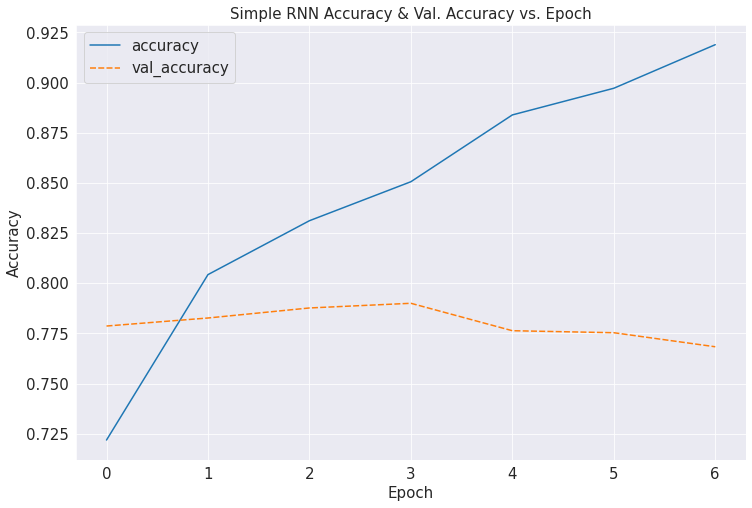

In [ ]:
history_rnn_df = pd.DataFrame(dict(history_rnn.history.items()))

plt.figure(figsize = (12, 8))
sns.lineplot(data = history_rnn_df[['accuracy', 'val_accuracy']])
plt.title('Simple RNN Accuracy & Val. Accuracy vs. Epoch', fontsize = 15)
plt.xlabel('Epoch', fontsize = 15)
plt.ylabel('Accuracy', fontsize = 15)
plt.tick_params(labelsize = 15)
plt.legend(fontsize = 15)

Save model to gdrive

In [ ]:
model_save_name = 'sentiment_rnn.pt'
path = F'/content/gdrive/My Drive/Fall 2021/EECS6895-BDA/Final Project/{model_save_name}'
model_rnn.save(path)

INFO:tensorflow:Assets written to: /content/gdrive/My Drive/Fall 2021/EECS6895-BDA/Final Project/sentiment_rnn.pt/assets


Train LSTM

In [ ]:
model_lstm = build_model(nb_words, "LSTM", embedding_matrix)
history_lstm = model_lstm.fit(train_X, train_y, epochs=20, batch_size=120,
          validation_data=(valid_X, valid_y), callbacks=EarlyStopping(monitor='val_accuracy', mode='max',patience=3))
predictions = model_lstm.predict(valid_X)
predictions = predictions.argmax(axis=1)
print(classification_report(valid_y.argmax(axis=1), predictions))

Epoch 1/20
59/59 [==============================] - 9s 117ms/step - loss: 0.5295 - accuracy: 0.7304 - val_loss: 0.4597 - val_accuracy: 0.7877
Epoch 2/20
59/59 [==============================] - 6s 107ms/step - loss: 0.4254 - accuracy: 0.8057 - val_loss: 0.4392 - val_accuracy: 0.7963
Epoch 3/20
59/59 [==============================] - 6s 106ms/step - loss: 0.3973 - accuracy: 0.8200 - val_loss: 0.4280 - val_accuracy: 0.7980
Epoch 4/20
59/59 [==============================] - 6s 110ms/step - loss: 0.3701 - accuracy: 0.8354 - val_loss: 0.4222 - val_accuracy: 0.8083
Epoch 5/20
59/59 [==============================] - 7s 112ms/step - loss: 0.3506 - accuracy: 0.8441 - val_loss: 0.4364 - val_accuracy: 0.8057
Epoch 6/20
59/59 [==============================] - 6s 108ms/step - loss: 0.3199 - accuracy: 0.8619 - val_loss: 0.4507 - val_accuracy: 0.7973
Epoch 7/20
59/59 [==============================] - 6s 107ms/step - loss: 0.2970 - accuracy: 0.8706 - val_loss: 0.4622 - val_accuracy: 0.8097
Epoch 

Plot LSTM Model Metrics

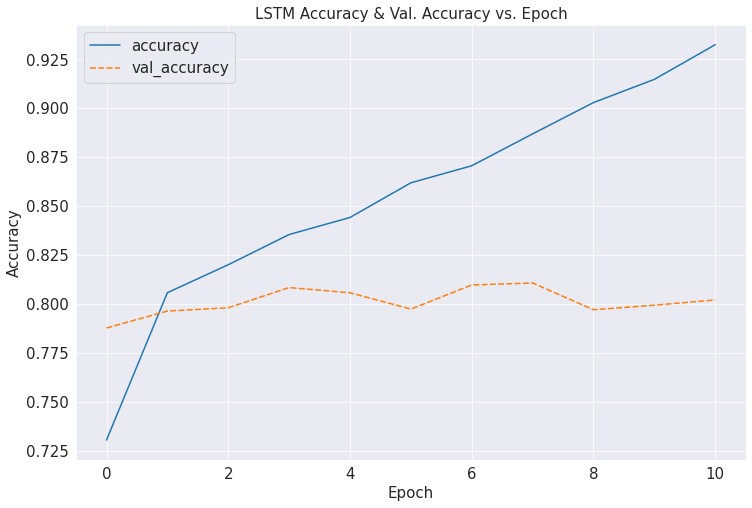

In [ ]:
history_lstm_df = pd.DataFrame(dict(history_lstm.history.items()))

plt.figure(figsize = (12, 8))
sns.lineplot(data = history_lstm_df[['accuracy', 'val_accuracy']])
plt.title('LSTM Accuracy & Val. Accuracy vs. Epoch', fontsize = 15)
plt.xlabel('Epoch', fontsize = 15)
plt.ylabel('Accuracy', fontsize = 15)
plt.tick_params(labelsize = 15)
plt.legend(fontsize = 15)

Save model to gdrive

In [ ]:
model_save_name = 'sentiment_lstm.pt'
path = F'/content/gdrive/My Drive/Fall 2021/EECS6895-BDA/Final Project/{model_save_name}'
model_lstm.save(path)

INFO:tensorflow:Assets written to: /content/gdrive/My Drive/Fall 2021/EECS6895-BDA/Final Project/sentiment_lstm.pt/assets


INFO:tensorflow:Assets written to: /content/gdrive/My Drive/Fall 2021/EECS6895-BDA/Final Project/sentiment_lstm.pt/assets


Train GRU

In [ ]:
model_gru = build_model(nb_words, "GRU", embedding_matrix)
history_gru = model_gru.fit(train_X, train_y, epochs=20, batch_size=120,
          validation_data=(valid_X, valid_y), callbacks=EarlyStopping(monitor='val_accuracy', mode='max',patience=3))
predictions = model_gru.predict(valid_X)
predictions = predictions.argmax(axis=1)
print(classification_report(valid_y.argmax(axis=1), predictions))

Epoch 1/20
59/59 [==============================] - 8s 99ms/step - loss: 0.5904 - accuracy: 0.6747 - val_loss: 0.4655 - val_accuracy: 0.7760
Epoch 2/20
59/59 [==============================] - 5s 88ms/step - loss: 0.4412 - accuracy: 0.7934 - val_loss: 0.4328 - val_accuracy: 0.7960
Epoch 3/20
59/59 [==============================] - 5s 90ms/step - loss: 0.4013 - accuracy: 0.8191 - val_loss: 0.4374 - val_accuracy: 0.8007
Epoch 4/20
59/59 [==============================] - 5s 89ms/step - loss: 0.3835 - accuracy: 0.8250 - val_loss: 0.4219 - val_accuracy: 0.7970
Epoch 5/20
59/59 [==============================] - 5s 89ms/step - loss: 0.3486 - accuracy: 0.8436 - val_loss: 0.4268 - val_accuracy: 0.8010
Epoch 6/20
59/59 [==============================] - 5s 89ms/step - loss: 0.3340 - accuracy: 0.8541 - val_loss: 0.4385 - val_accuracy: 0.8017
Epoch 7/20
59/59 [==============================] - 5s 89ms/step - loss: 0.2979 - accuracy: 0.8707 - val_loss: 0.4739 - val_accuracy: 0.8073
Epoch 8/20
59

Plot GRU Model Metrics

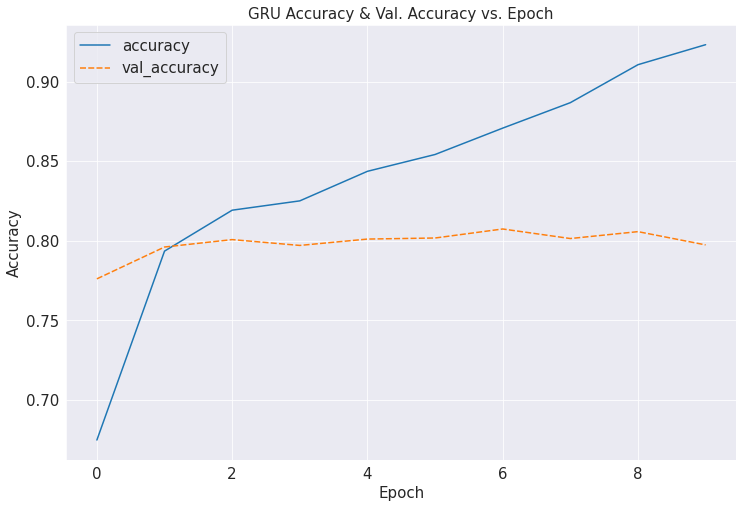

In [ ]:
history_gru_df = pd.DataFrame(dict(history_gru.history.items()))

plt.figure(figsize = (12, 8))
sns.lineplot(data = history_gru_df[['accuracy', 'val_accuracy']])
plt.title('GRU Accuracy & Val. Accuracy vs. Epoch', fontsize = 15)
plt.xlabel('Epoch', fontsize = 15)
plt.ylabel('Accuracy', fontsize = 15)
plt.tick_params(labelsize = 15)
plt.legend(fontsize = 15)

Save model to gdrive

In [ ]:
model_save_name = 'sentiment_gru.pt'
path = F'/content/gdrive/My Drive/Fall 2021/EECS6895-BDA/Final Project/{model_save_name}'
model_gru.save(path)

INFO:tensorflow:Assets written to: /content/gdrive/My Drive/Fall 2021/EECS6895-BDA/Final Project/sentiment_gru.pt/assets


INFO:tensorflow:Assets written to: /content/gdrive/My Drive/Fall 2021/EECS6895-BDA/Final Project/sentiment_gru.pt/assets
